In [1]:
from typing import Callable

import astropy.constants as const
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from plotting import label_axes

# Problem statement

We describe cosmic rays with one-dimensional density, parametrized with energy $f(z, E) \equiv \frac{dN}{dz dE}$.

1D diffusion equation in presence of a constant source term $Q$ from supernovas and $pp \to \pi X$
absorption term, characterized by timescale $\tau$. Injection spectrum is assumed to follow power law with generic lower energy $E_0$ and
spectral index $\alpha$

$$
\frac{\partial f}{\partial t}
=D(E) \frac{\partial^2 f}{\partial z^2} + Q(E) - \frac{f}{\tau(E)}
\\
Q(E) = \frac{R^{\text{(SN)}}}{2 H} (\alpha - 2) \frac{E^{\text{(SN)}}}{E_0^2}\left( \frac{E}{E_0} \right)^{-\alpha}
\\
\tau(E) = \frac{1}{n_{\text{gas}} \sigma(E) v(E)} = \frac{1}{n_{\text{gas}} \sigma(E) c \sqrt{1 - (m_p c^2 / E)^2}}
$$

Solution for stationary case can be found analytically.


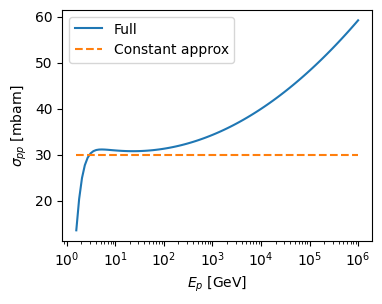

In [12]:
E_pp_threshold = 1.22 * u.GeV


def sigma_pp_full(E: u.Quantity[u.eV]) -> u.Quantity[u.mbarn]:
    above_thresh = E > E_pp_threshold
    result = np.zeros_like(E).value * u.mbarn
    lnE = np.log(E[above_thresh].to(u.TeV).value)
    result[above_thresh] = (
        (34.3 + 1.88 * lnE + 0.25 * lnE**2)
        * (1 - (E_pp_threshold / E[above_thresh]) ** 4) ** 2
    ) * u.mbarn
    return result


def sigma_pp_approx(E: u.Quantity[u.eV]) -> u.Quantity[u.mbarn]:
    return 3e-26 * np.ones_like(E).value * u.cm**2


_, ax = plt.subplots(figsize=(4, 3))

E_p_grid = np.logspace(np.log(E_pp_threshold.to(u.GeV).value), 6, 100) * u.GeV
ax.plot(E_p_grid, sigma_pp_full(E_p_grid), label="Full")
ax.plot(E_p_grid, sigma_pp_approx(E_p_grid), linestyle="--", label="Constant approx")
ax.set_xscale("log")
label_axes(ax, "E_p", "\\sigma_{pp}")
ax.legend()
plt.show()

In [4]:
SigmaPPType = Callable[[u.Quantity[u.eV]], u.Quantity[u.mbarn]]

In [5]:
H = 0.5 * u.kpc
n_gas = 300 / u.cm**3

R_SN = 1 / (10 * u.yr)
E_SN = 1e50 * u.erg

alpha = 3
E_0 = 1 * u.GeV


def D_coeff(E: u.Quantity[u.eV]) -> u.Quantity[u.cm**2 / u.s]:
    return 3e26 * (E.to(u.GeV).value) ** (1 / 3) * u.cm**2 / u.s


def tau_absorption(E: u.Quantity[u.eV], sigma: SigmaPPType) -> u.Quantity[u.yr]:
    return 1 / (
        n_gas * sigma(E) * const.c * np.sqrt(1 - ((const.m_p * const.c**2) / E) ** 2)
    )


def Q_supernovae(E: u.Quantity[u.eV]) -> u.Quantity[1 / (u.yr * u.pc * u.eV)]:
    return (R_SN * (alpha - 2) / (2 * H)) * (E_SN / E_0**2) * (E / E_0) ** (-alpha)


def L_diff_absorption(E: u.Quantity[u.eV], sigma: SigmaPPType) -> u.Quantity[u.pc]:
    """Characteristic length of diffusion with absorption"""
    return np.sqrt(D_coeff(E) * tau_absorption(E, sigma))


def stationary_solution_f(
    z: u.Quantity[u.pc],
    E: u.Quantity[u.eV],
    sigma: SigmaPPType,
) -> u.Quantity[1 / (u.kpc * u.eV)]:
    tau = tau_absorption(E, sigma)
    Q = Q_supernovae(E)
    L = L_diff_absorption(E, sigma)
    return (
        (Q * tau)
        * (1 - (np.exp(z / L) + np.exp(-z / L)) / (np.exp(H / L) + np.exp(-H / L)))
    ).to(1 / (u.pc * u.eV))

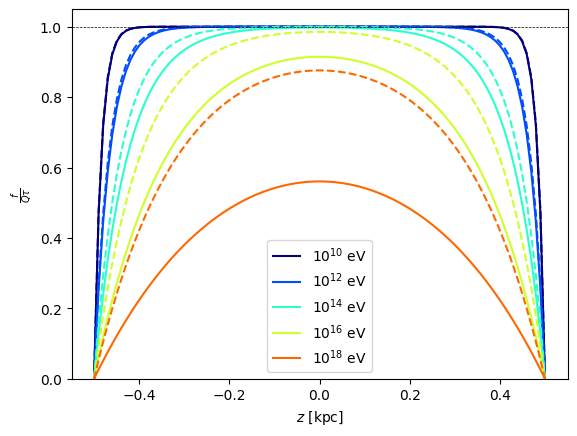

In [9]:
_, ax = plt.subplots()

z_grid = np.linspace(-H, H, 100)
E_exps = [10, 12, 14, 16, 18]
cmap = matplotlib.colormaps["jet"]
for idx, E_exp in enumerate(E_exps):
    color = cmap(idx / len(E_exps))
    E = (10**E_exp) * u.eV
    no_diffusion_f = Q_supernovae(E) * tau_absorption(E, sigma=sigma_pp_approx)
    ax.plot(
        z_grid,
        (
            stationary_solution_f(z_grid, E=E, sigma=sigma_pp_approx) / no_diffusion_f
        ).decompose(),
        label=f"$ 10^{{{E_exp}}} $ eV",
        color=color,
    )

    no_diffusion_f = Q_supernovae(E) * tau_absorption(E, sigma=sigma_pp_full)
    ax.plot(
        z_grid,
        (
            stationary_solution_f(z_grid, E=E, sigma=sigma_pp_full) / no_diffusion_f
        ).decompose(),
        color=color,
        linestyle="--",
    )

ax.axhline(1, color="k", linestyle="--", linewidth=0.5)
ax.set_ylim(bottom=0)
label_axes(ax, "z", "\\frac{f}{Q\\tau}")
ax.legend()
plt.show()

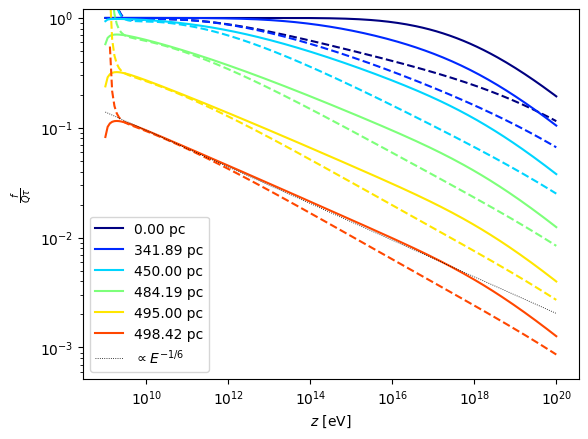

In [28]:
_, ax = plt.subplots()

z_values = (H - H * np.logspace(0, -2.5, num=6)).to(u.pc)
E_grid = np.logspace(-3, 8, 200) * u.TeV
cmap = matplotlib.colormaps["jet"]
Q_tau = Q_supernovae(E_grid) * tau_absorption(E_grid, sigma=sigma_pp_approx)
Q_tau_full_sigma = Q_supernovae(E_grid) * tau_absorption(E_grid, sigma=sigma_pp_full)
for idx, z in enumerate(z_values):
    color = cmap(idx / len(z_values))
    ax.loglog(
        E_grid.to(u.eV),
        (stationary_solution_f(z, E=E_grid, sigma=sigma_pp_approx) / Q_tau).decompose(),
        label=f"{z:.2f}",
        color=color,
    )
    ax.loglog(
        E_grid.to(u.eV),
        (stationary_solution_f(z, E=E_grid, sigma=sigma_pp_full) / Q_tau).decompose(),
        color=color,
        linestyle="--",
    )

ax.plot(
    E_grid,
    4.4e-2 * (E_grid ** (-1 / 6)).value,
    color="k",
    linestyle=":",
    linewidth=0.6,
    label="$ \\propto E^{-1/6} $",
)
label_axes(ax, "z", "\\frac{f}{Q\\tau}")
ax.set_ylim(top=1.2)
ax.legend()
plt.show()

## Escape spectrum

To determine the escape spectrum, we can consider a particle balance at equilibrium:
- Per unit time $d t$, $2 H Q(E) dt$ particles are injected into a system
- At the same time, $\displaystyle \frac{d t}{\tau(E)} \int_{-H}^{H} f(z, E) dz$ particles die out
  due to inelastic scattering

The difference between the two quantities is the number of particles that escaped, giving the escape spectrum.
Dividing by $dt$, we ge the emissivity $Q(E) \equiv \frac{dN}{dE dt}$

In [29]:
def escape_spectrum(
    E: u.Quantity[u.eV], sigma: SigmaPPType
) -> u.Quantity[1 / (u.eV * u.yr)]:
    Q = Q_supernovae(E)
    L = L_diff_absorption(E, sigma=sigma)
    return (
        2 * Q * L * (np.exp(H / L) - np.exp(-H / L)) / (np.exp(H / L) + np.exp(-H / L))
    ).to(1 / (u.eV * u.yr))

/Users/njvh/Documents/Science/GSSI/HEAPTH/exam/venv/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/njvh/Documents/Science/GSSI/HEAPTH/exam/venv/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


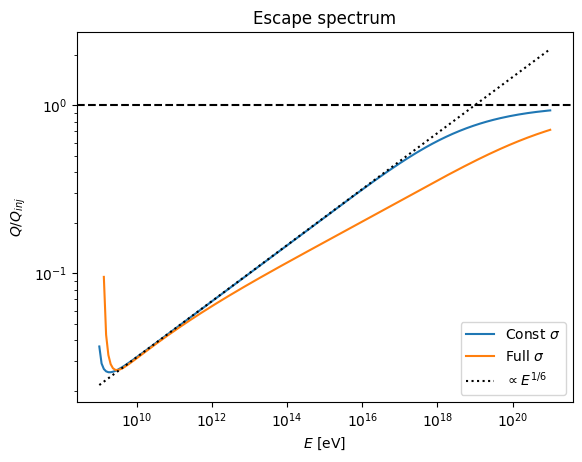

In [68]:
_, ax = plt.subplots()

E_grid = np.logspace(-3, 9, 200) * u.TeV
injection = (2 * H * Q_supernovae(E_grid)).to(1 / (u.eV * u.yr))
ax.loglog(
    E_grid.to(u.eV),
    escape_spectrum(E_grid, sigma=sigma_pp_approx) / injection,
    label="Const $\\sigma$",
)
ax.loglog(
    E_grid,
    escape_spectrum(E_grid, sigma=sigma_pp_full) / injection,
    label="Full $\\sigma$",
)
ax.loglog(
    E_grid,
    0.0685 * (E_grid ** (1 / 6)).value,
    color="black",
    linestyle=":",
    label="$ \\propto E^{1/6} $",
)
ax.axhline(1, color="black", linestyle="--")

label_axes(ax, "E", "Q / Q_{inj}")
ax.set_title("Escape spectrum")
ax.legend()
plt.show()

## Escape and loss timescales

- Diffusive escape timescale: $\tau_{diff} = \frac{H^2}{D(E)}$
- Inelastic scattering logg timescale: $\tau_{loss} = \frac{1}{n_{\text{gas}} \sigma v(E)}$

/Users/njvh/Documents/Science/GSSI/HEAPTH/exam/venv/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


pp: 30.0 mbarn Fe: 753.258658865295 mbarn


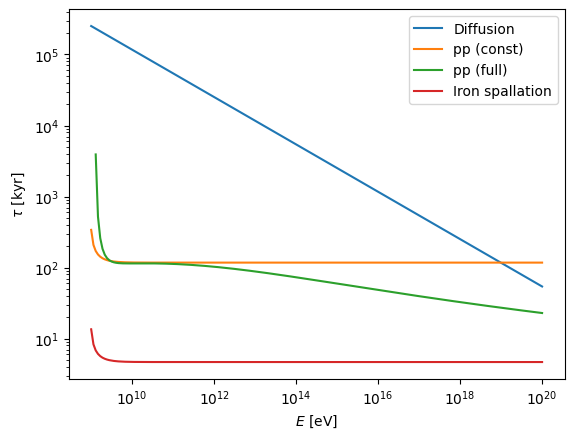

In [66]:
_, ax = plt.subplots()

E_grid = np.logspace(-3, 8, 200) * u.TeV
ax.loglog(E_grid.to(u.eV), (H**2 / D_coeff(E_grid)).to(u.kyr), label="Diffusion")
ax.loglog(E_grid, tau_absorption(E_grid, sigma=sigma_pp_approx), label="pp (const)")
ax.loglog(E_grid, tau_absorption(E_grid, sigma=sigma_pp_full), label="pp (full)")
sigma_Fe = 56**0.7 * 45 * u.mbarn
print("pp:", sigma_pp_approx(1 * u.eV).to(u.mbarn), "Fe:", sigma_Fe)
ax.loglog(E_grid, tau_absorption(E_grid, sigma=lambda _ : sigma_Fe), label="Iron spallation")

label_axes(ax, "E", "\\tau")
ax.legend()
plt.show()